In [1]:
# This script classifies all events into positive, negative,
# and neutral events, and look into the impact of using
# different thresholds.

In [9]:
import sys
print(sys.version)
sys.path.append("../")

from datetime import datetime

from typing import List, Union

import matplotlib.pyplot as plt
plt.style.use("grayscale")

plt.rcParams["figure.figsize"] = (9, 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = False

import seaborn as sns

import numpy as np
import pandas as pd

import scipy.stats as stats

from data_proc.rpna_processing import *

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
fig_path = "/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/figures/event_classification"

In [10]:
load = lambda x: pd.read_csv(
    x,
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)
# Load crude oil dataset
df = pd.read_csv("../data/ravenpack/crude_oil_all.csv")
df["ESS"]= df["ESS"] - 50
df["WESS"] = df["ESS"] * df["ENS"] / 100
df = convert_timestamp_wti(df)

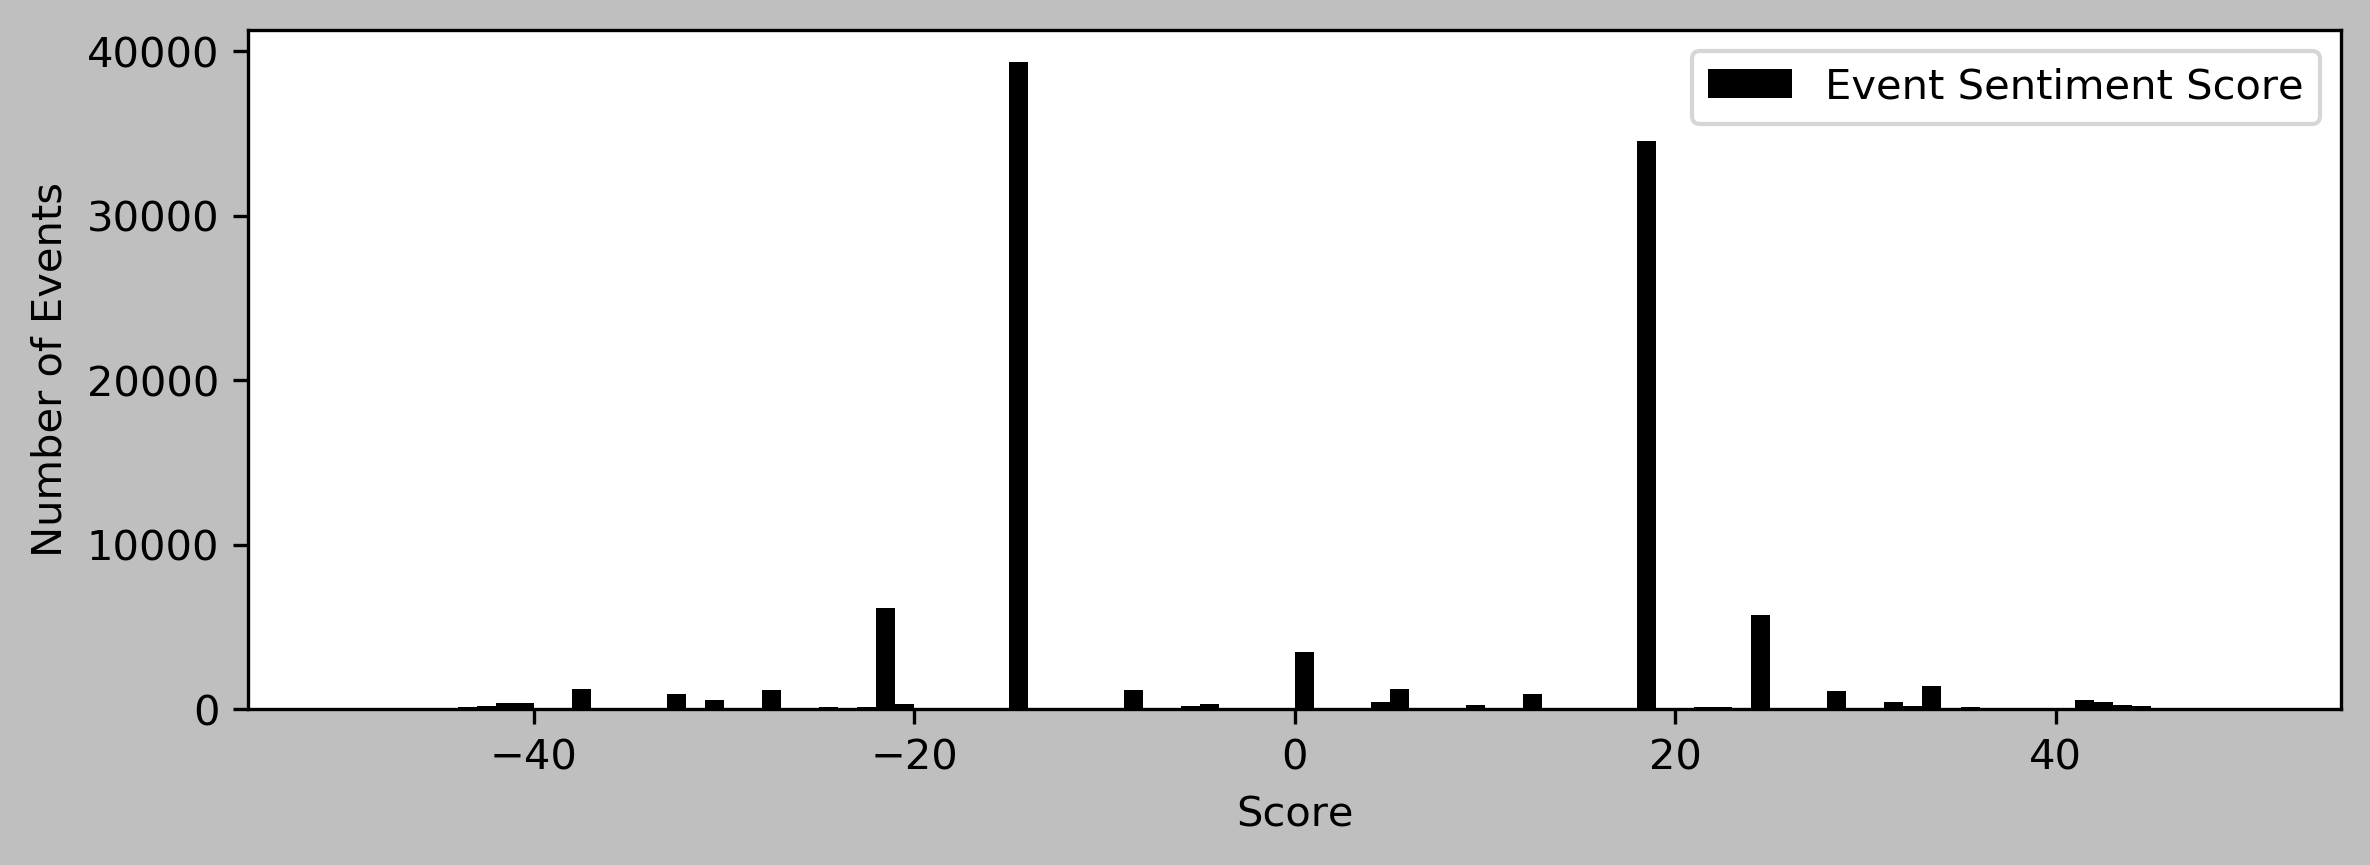

In [11]:
plt.hist(
    df["ESS"],
    label="Event Sentiment Score",
    bins=100
)
plt.xlabel("Score")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"{fig_path}/hist_ess_all.png", dpi=300, bbox_inches="tight")
plt.show()

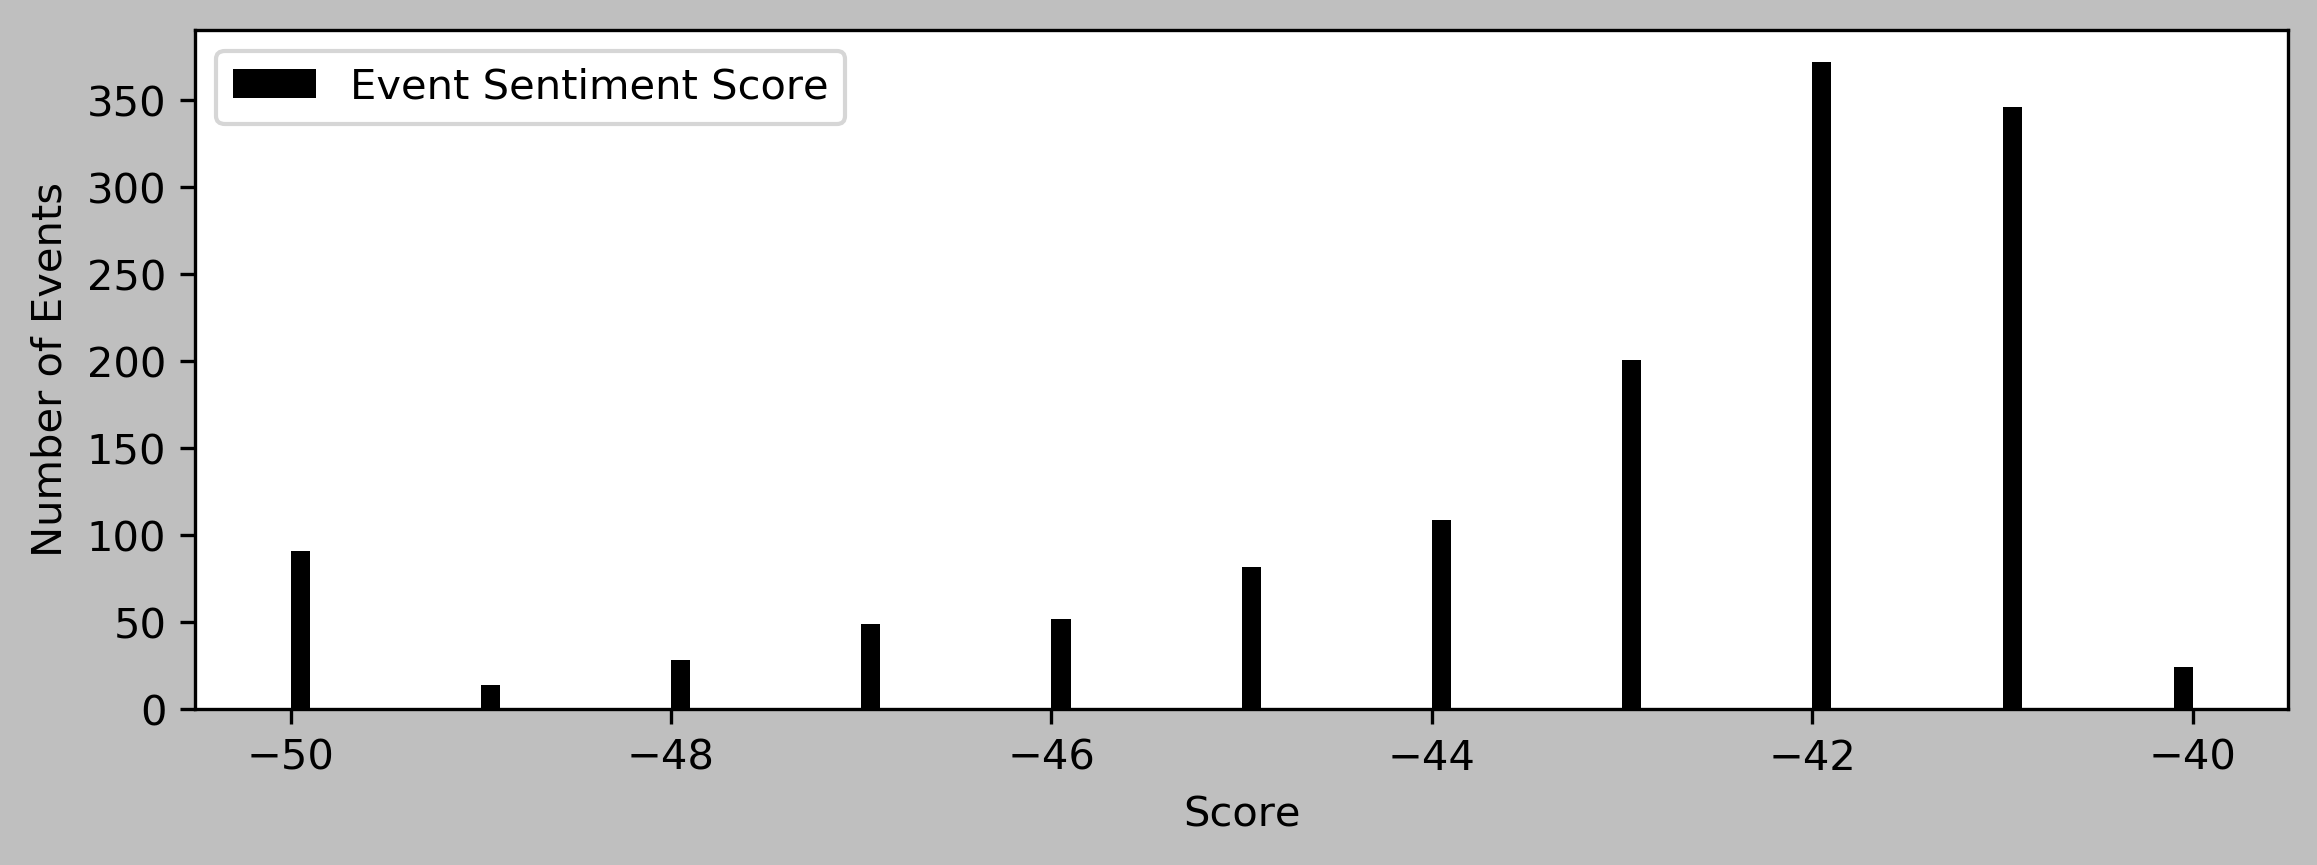

In [14]:
# Zoom in
df_filtered = df[df["ESS"] <= -40]
plt.hist(
    df_filtered["ESS"],
    label="Event Sentiment Score",
    bins=100
)
plt.xlabel("Score")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"{fig_path}/hist_ess_negative.png", dpi=300, bbox_inches="tight")
plt.show()

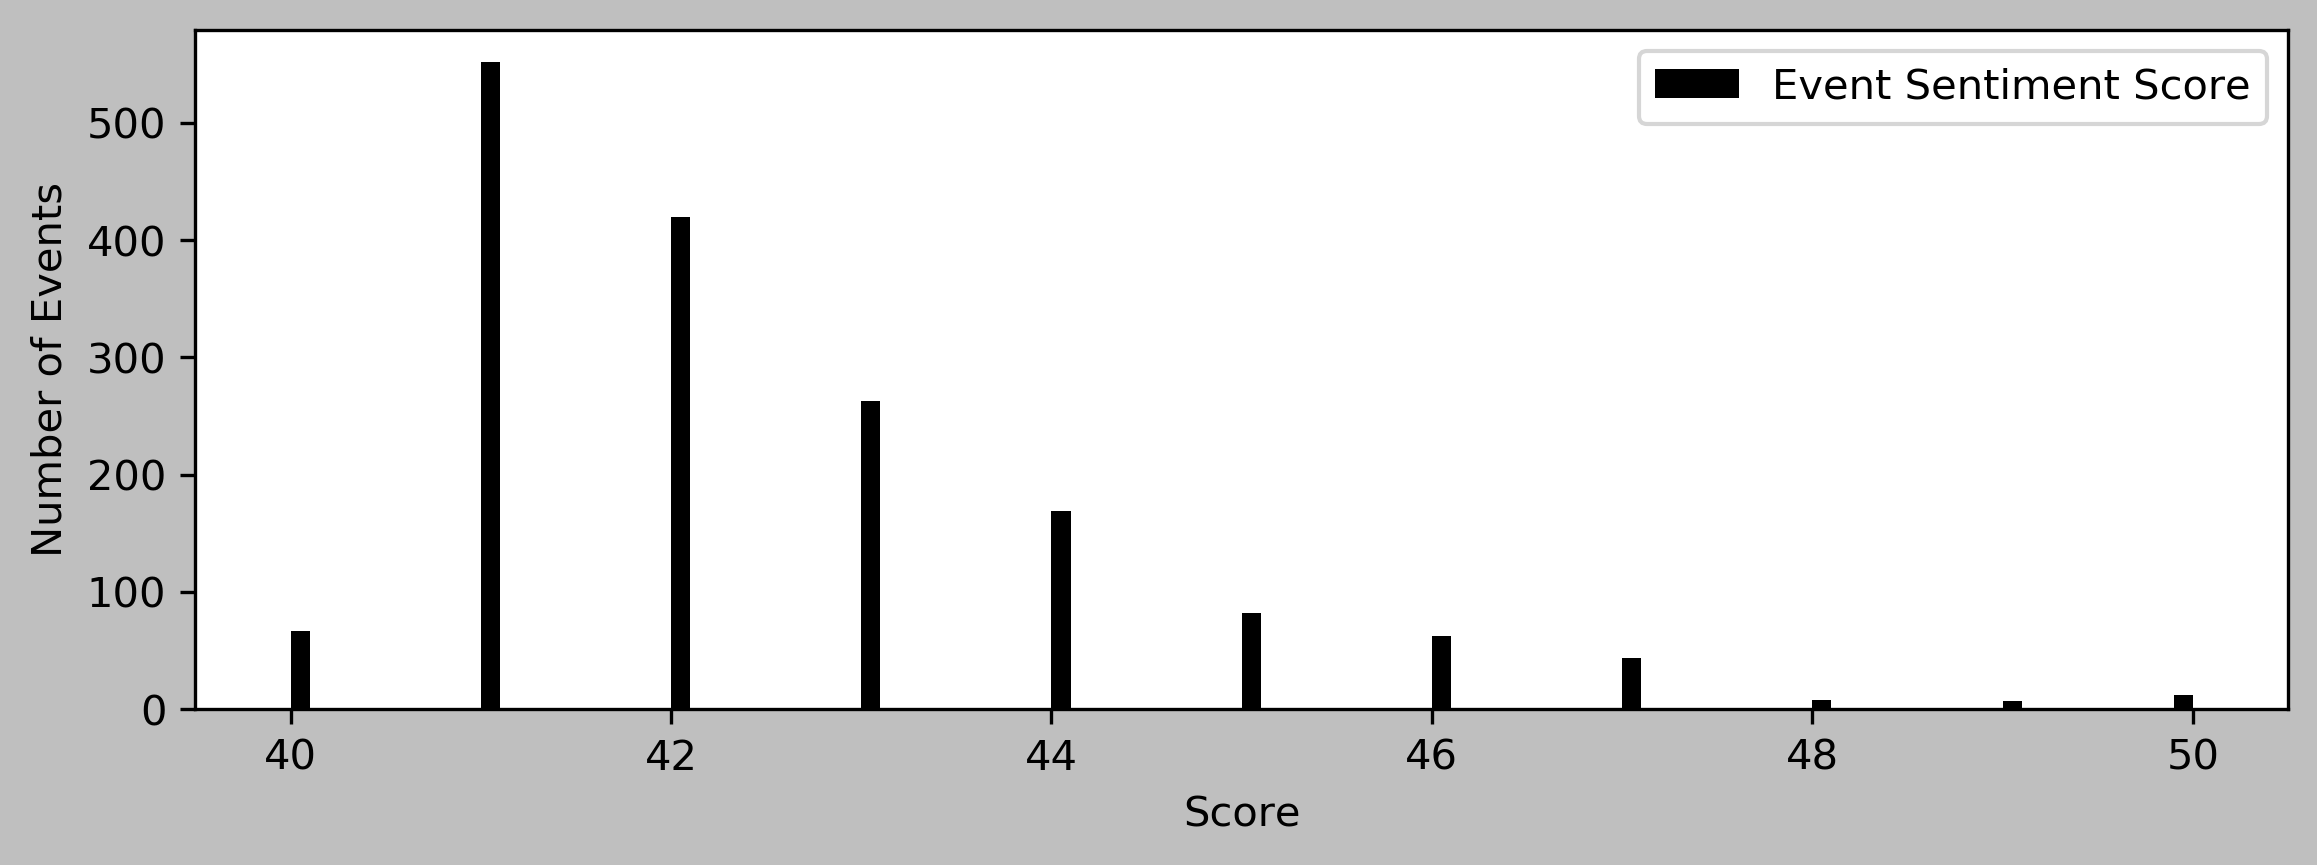

In [15]:
# Zoom in
df_filtered = df[df["ESS"] >= 40]
plt.hist(
    df_filtered["ESS"],
    label="Event Sentiment Score",
    bins=100
)
plt.xlabel("Score")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"{fig_path}/hist_ess_positive.png", dpi=300, bbox_inches="tight")
plt.show()

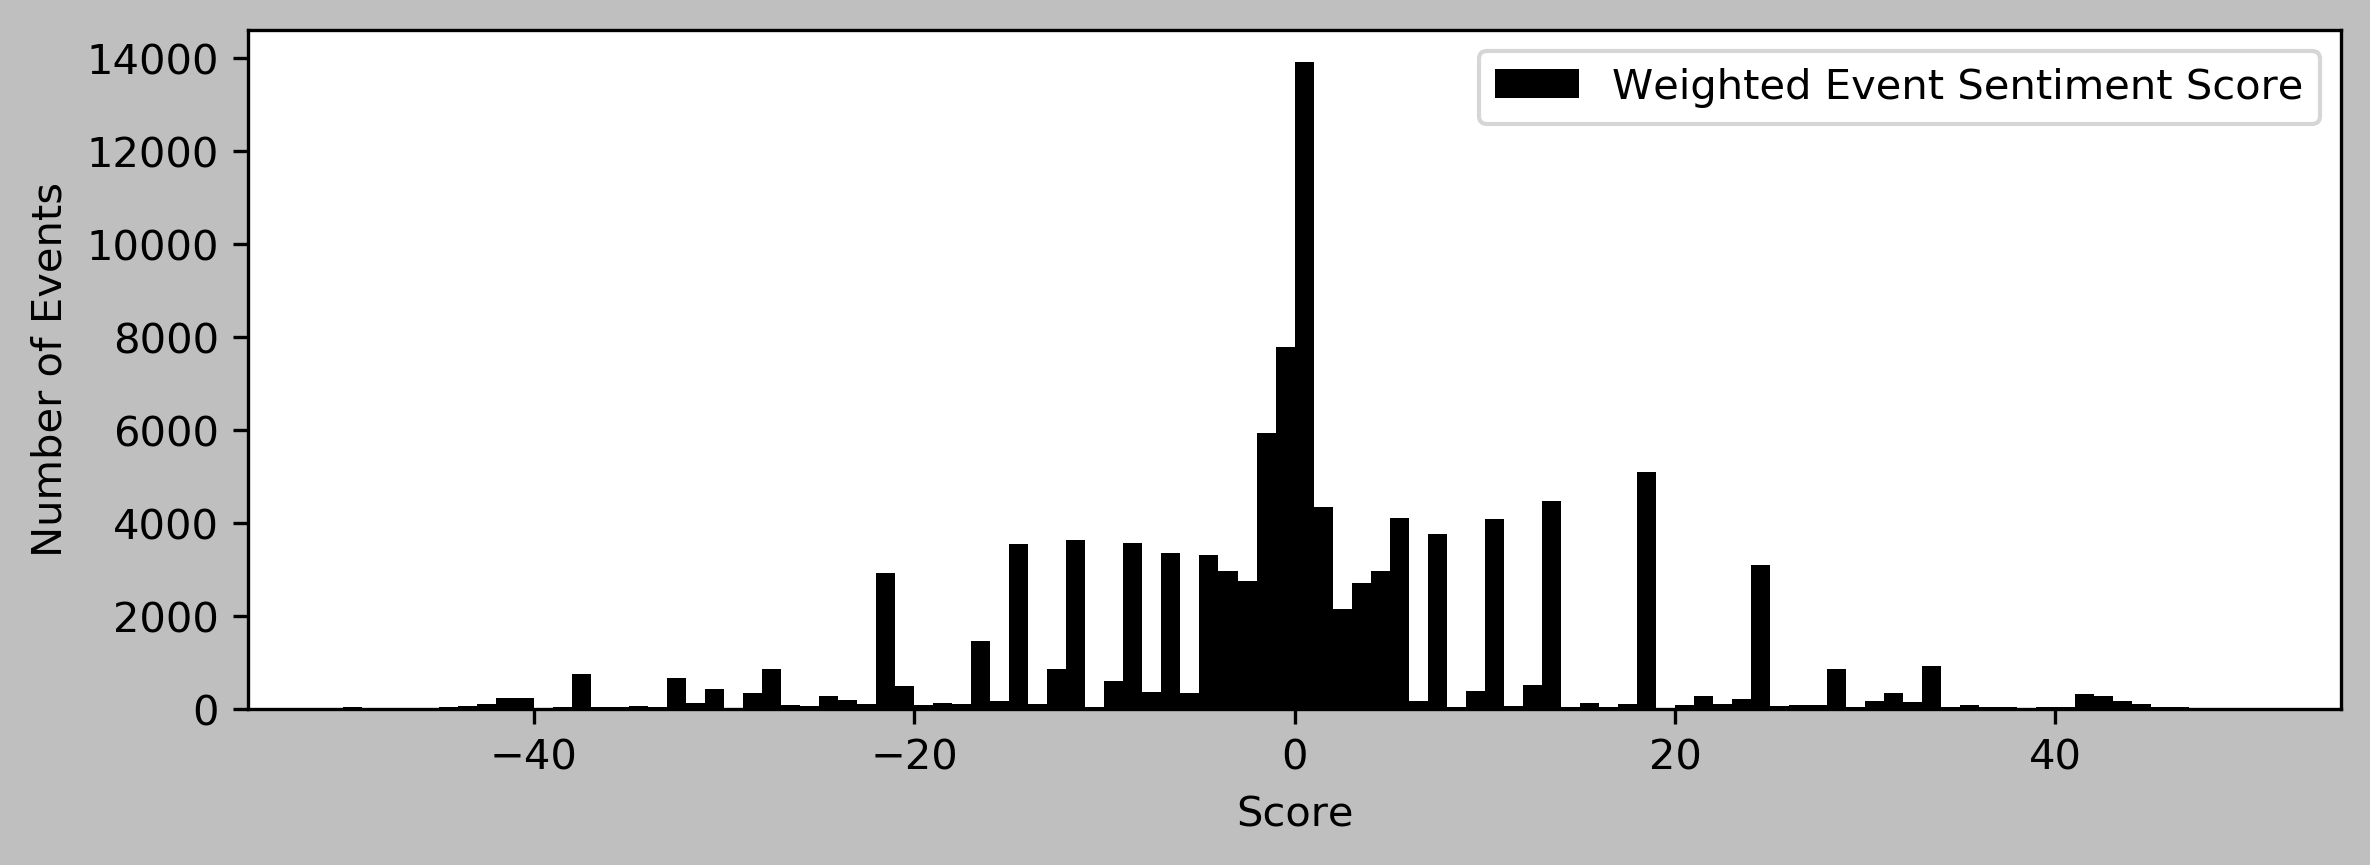

In [20]:
plt.hist(
    df["WESS"],
    label="Weighted Event Sentiment Score",
    bins=100
)
plt.xlabel("Score")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"{fig_path}/hist_wess_all.png", dpi=300, bbox_inches="tight")
plt.show()

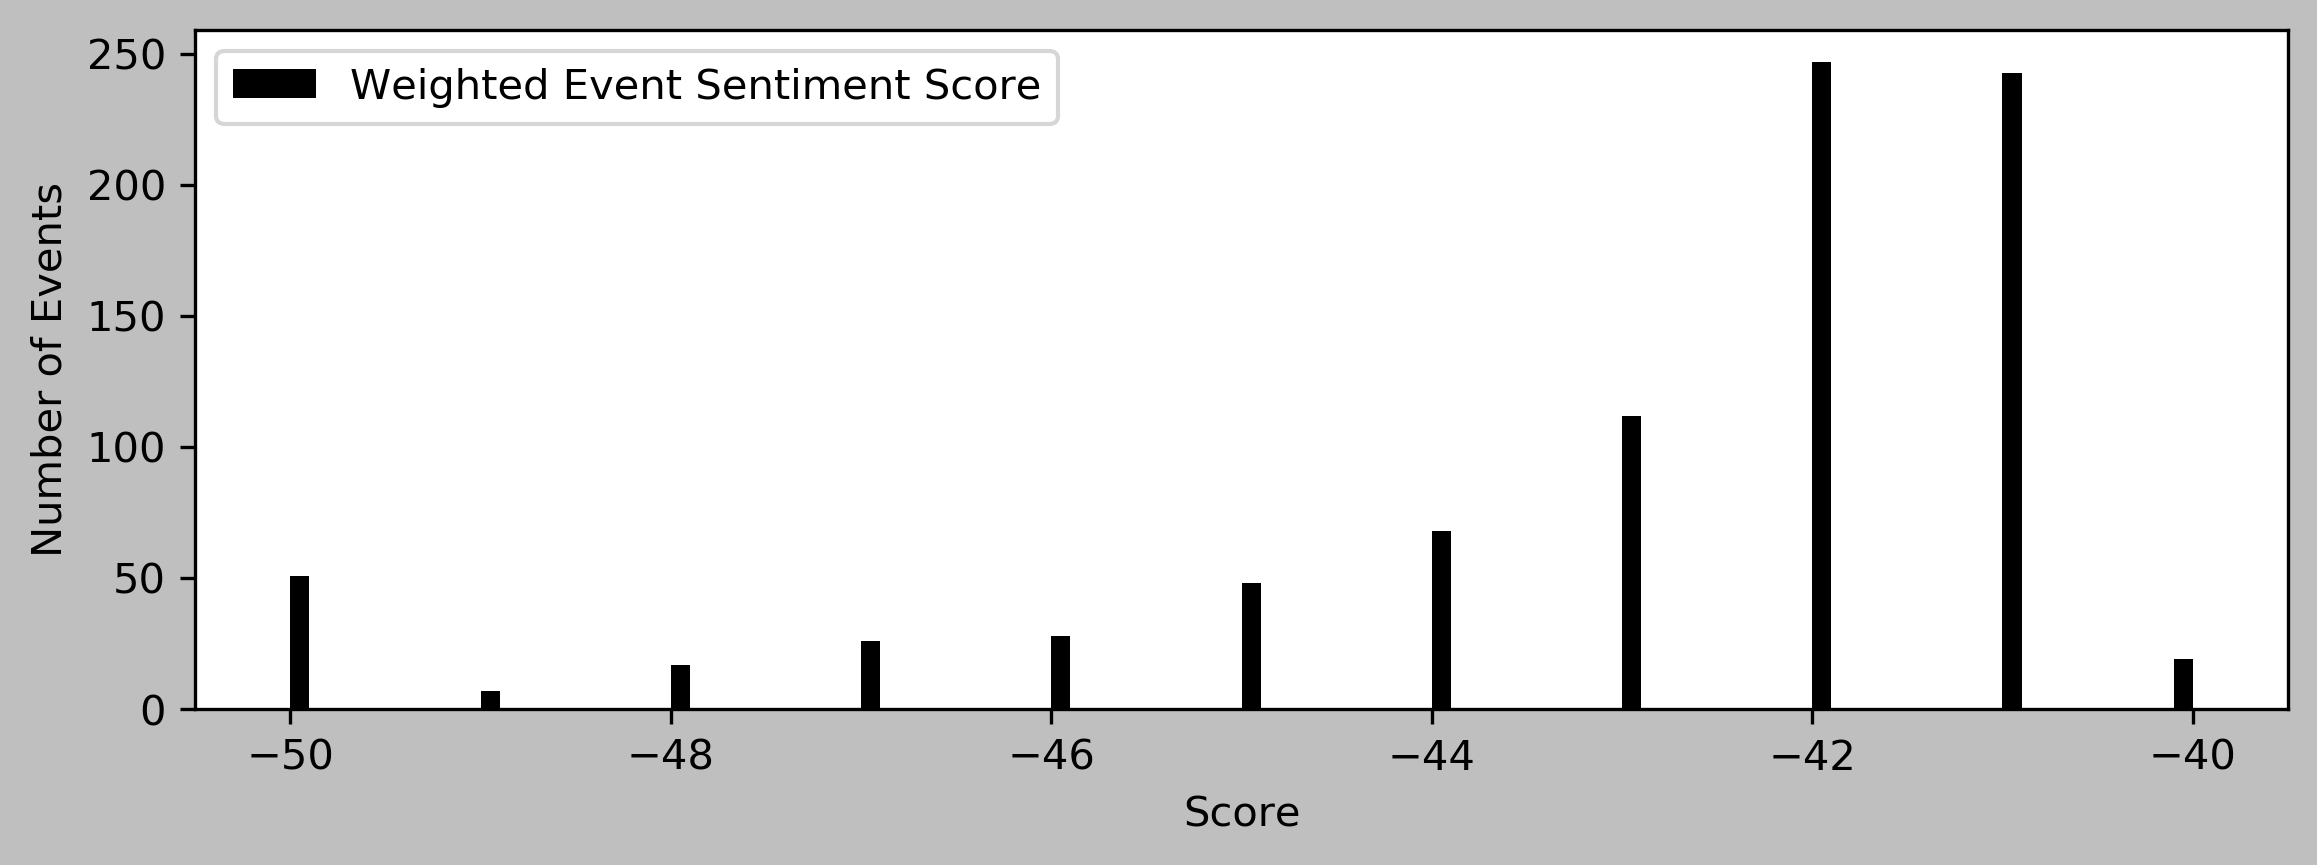

In [29]:
# zoom in
df_filtered = df[df["WESS"] <= -40]
plt.hist(
    df_filtered["WESS"],
    label="Weighted Event Sentiment Score",
    bins=100
)
plt.xlabel("Score")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"{fig_path}/hist_wess_negative.png", dpi=300, bbox_inches="tight")
plt.show()

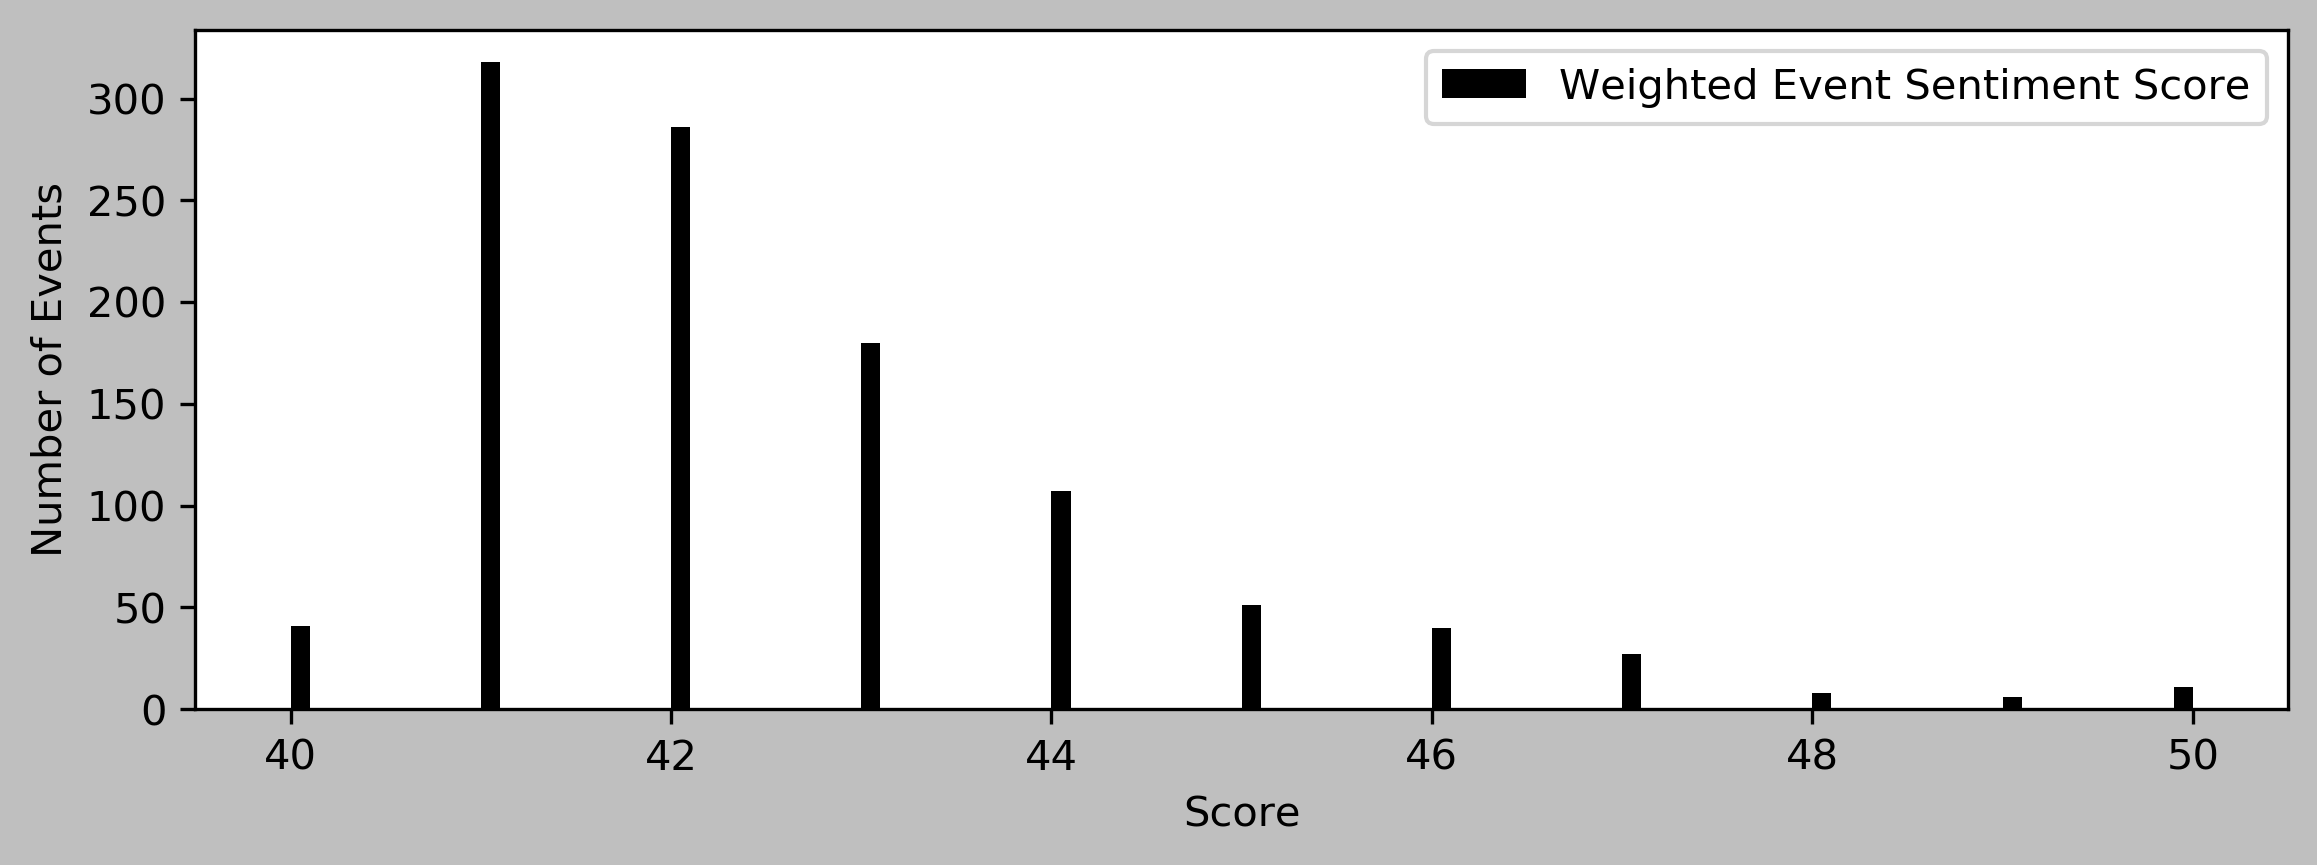

In [30]:
# zoom in
df_filtered = df[df["WESS"] >= 40]
plt.hist(
    df_filtered["WESS"],
    label="Weighted Event Sentiment Score",
    bins=100
)
plt.xlabel("Score")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"{fig_path}/hist_wess_positive.png", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
# For each year
date = df[["TIMESTAMP_WTI"]].copy()
years = date["TIMESTAMP_WTI"].apply(lambda t: datetime.strftime(t, "%Y")).values.astype(np.int32)

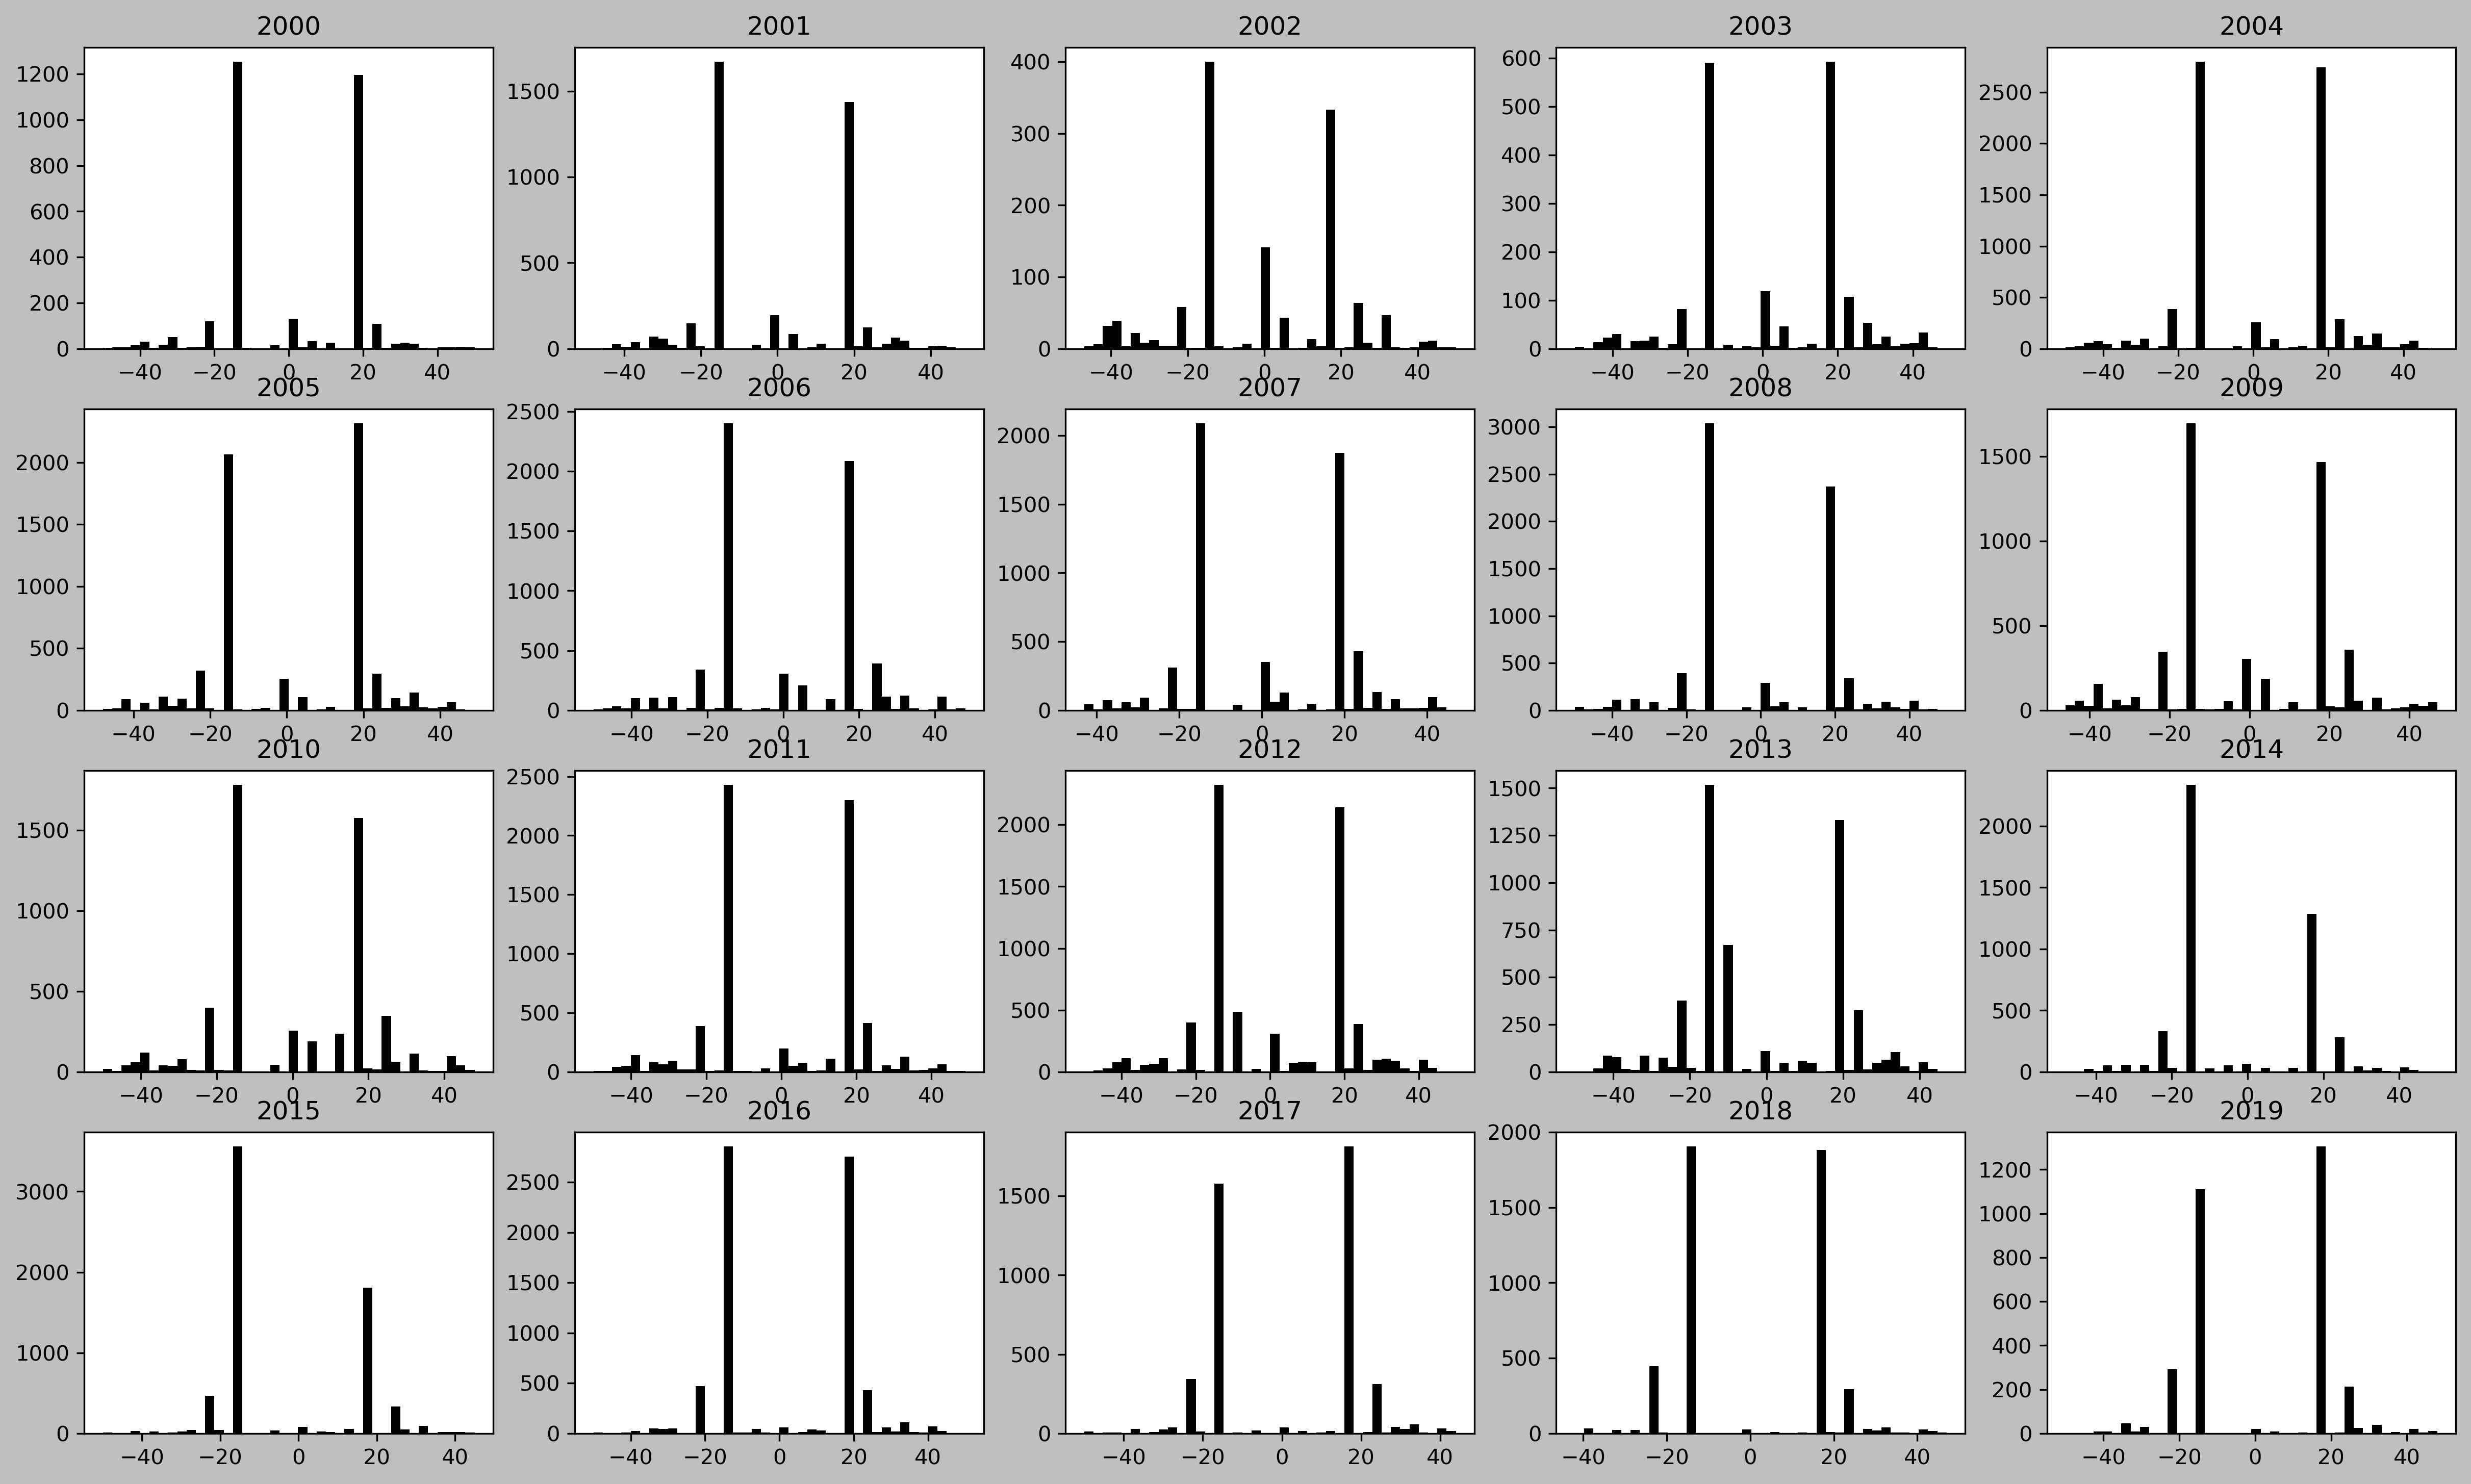

In [27]:
fig, ax_lst = plt.subplots(4, 5, figsize=(20, 12))
ax_lst = ax_lst.ravel()
for ax, yr in zip(ax_lst, range(2000, 2020)):
    mask = (years == yr)
    val = df[["ESS"]][mask].values.squeeze()
    ax.set_title(yr)
    ax.hist(val, bins=40)
plt.savefig(f"{fig_path}/hist_ess_years.png", dpi=300, bbox_inches="tight")
plt.show()

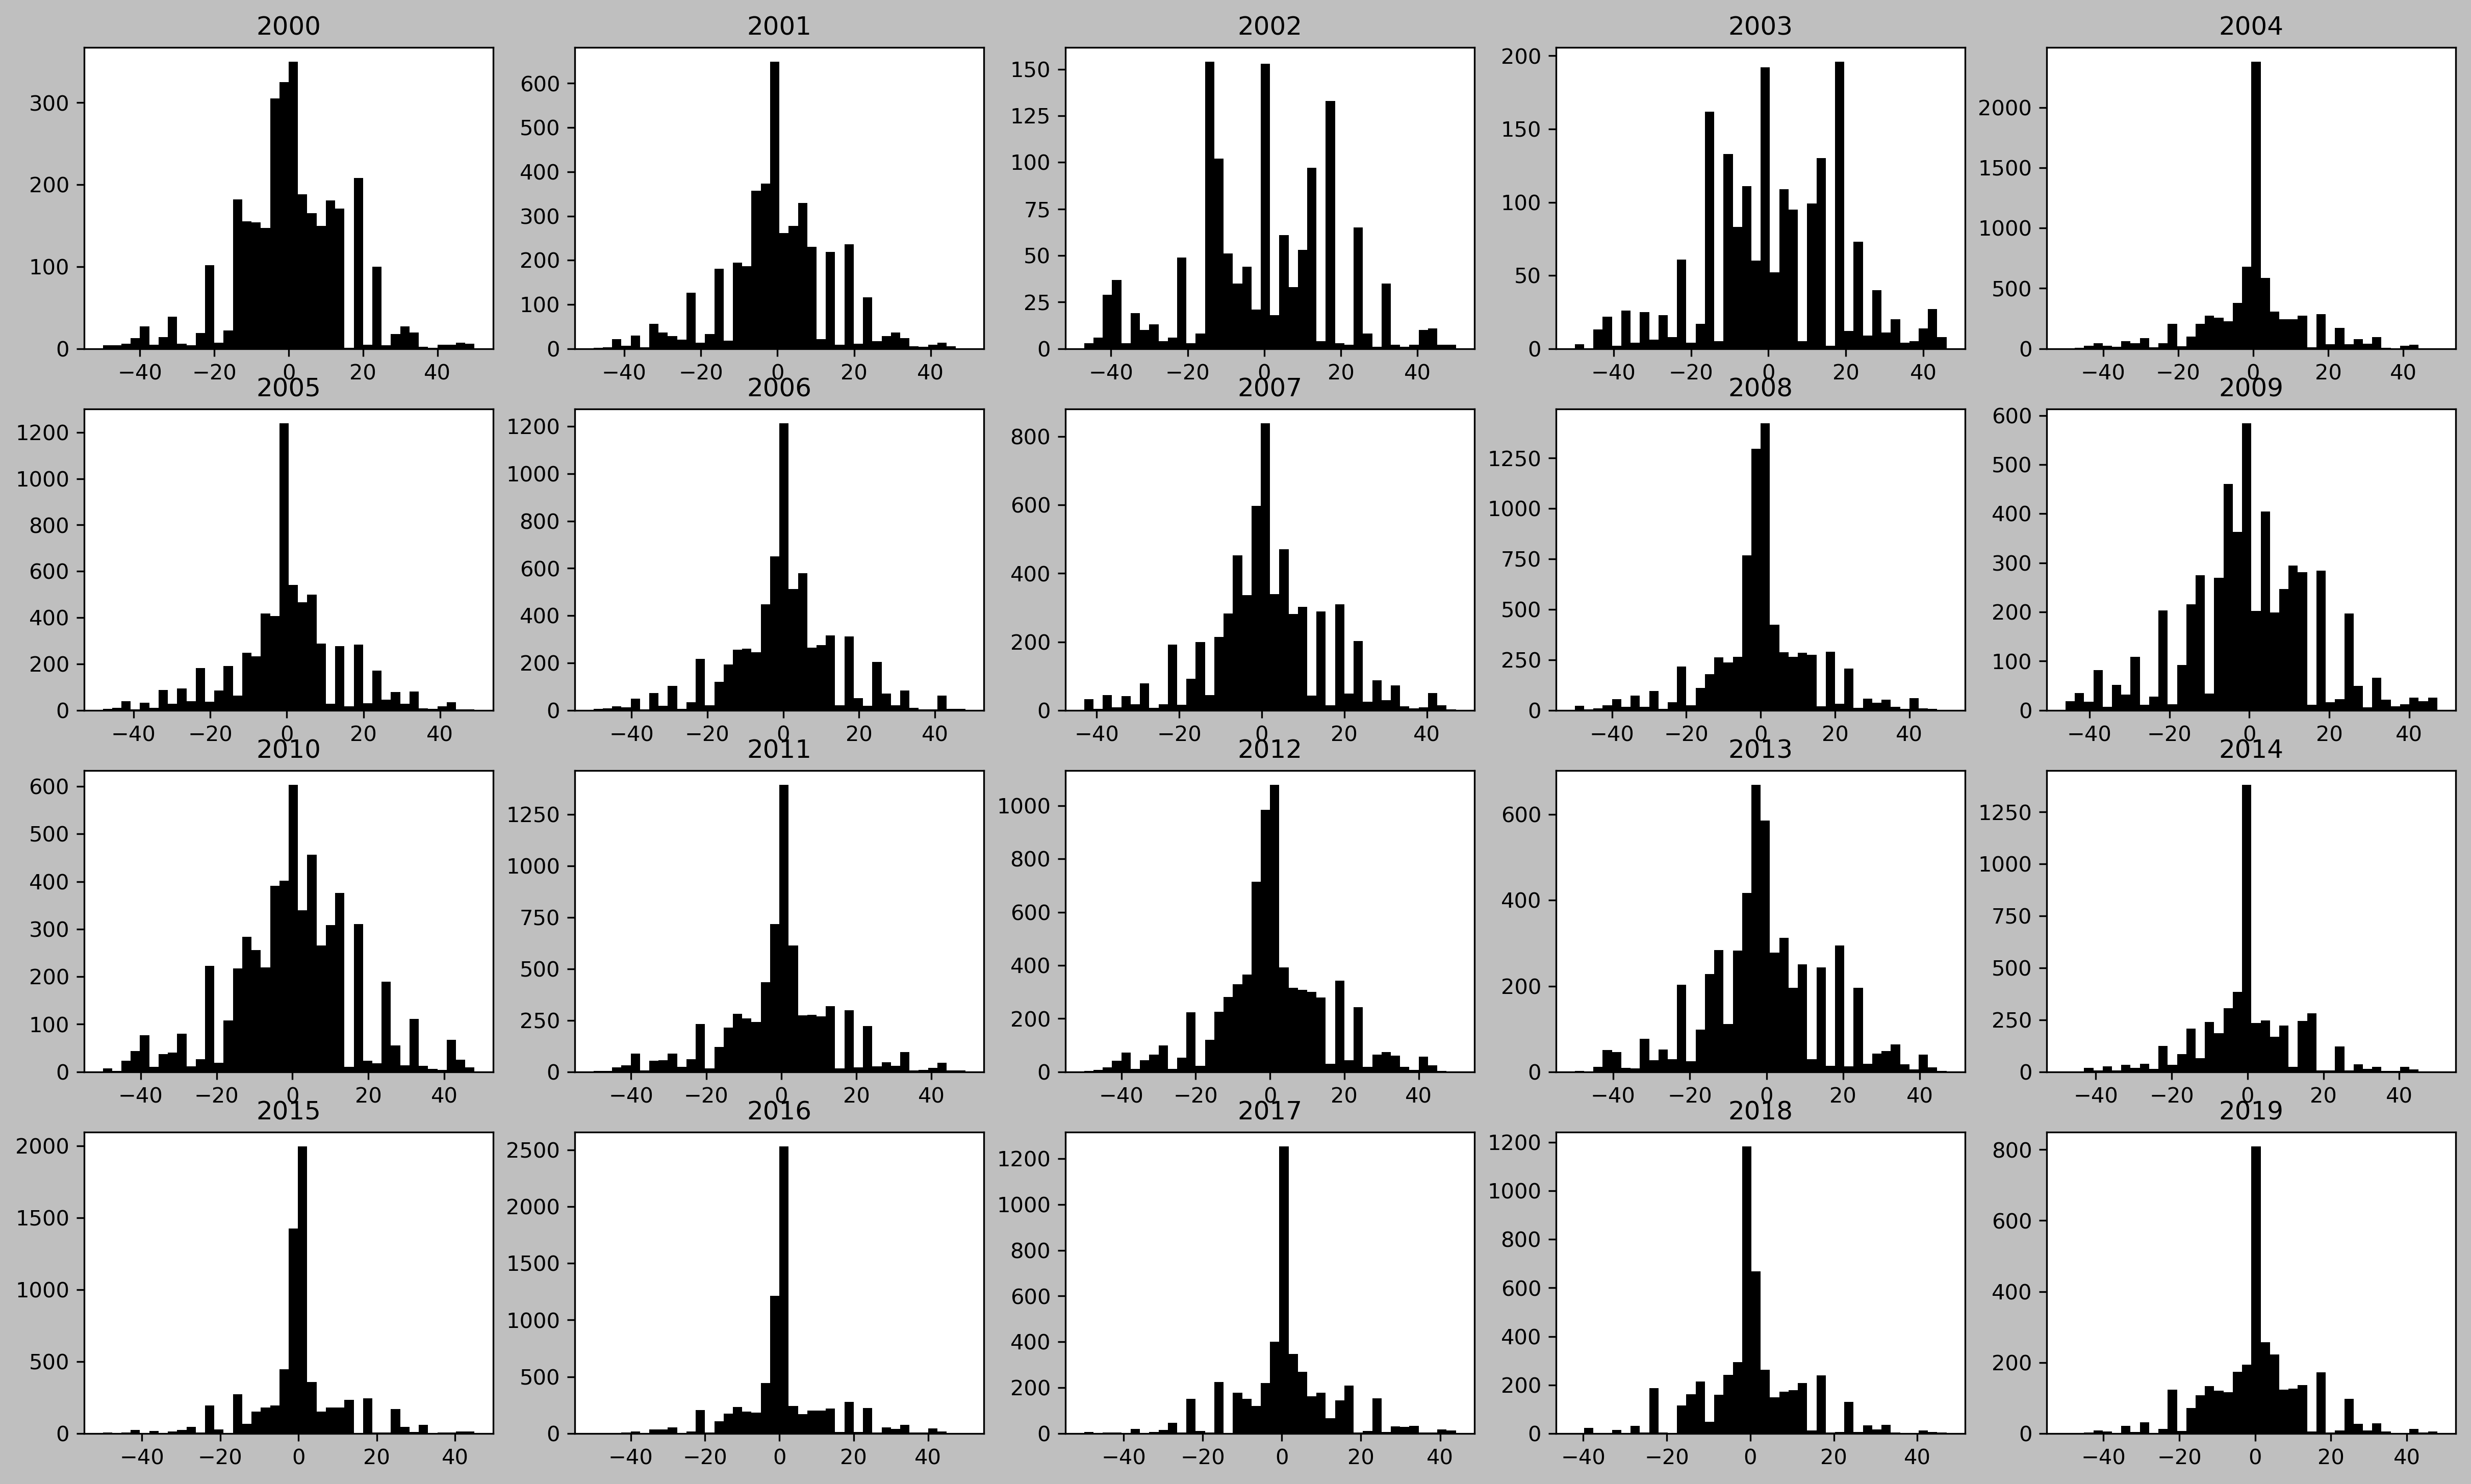

In [28]:
fig, ax_lst = plt.subplots(4, 5, figsize=(20, 12))
ax_lst = ax_lst.ravel()
for ax, yr in zip(ax_lst, range(2000, 2020)):
    mask = (years == yr)
    val = df[["WESS"]][mask].values.squeeze()
    ax.set_title(yr)
    ax.hist(val, bins=40)
plt.savefig(f"{fig_path}/hist_wess_years.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
print(df.columns)
features = ['TIMESTAMP_WTI', 'ENTITY_TYPE', 'ENTITY_NAME', 'RELEVANCE', 'TOPIC', 'GROUP', 'TYPE',
       'SUB_TYPE', 'PROPERTY', 'CATEGORY', 'ESS', 'AES', 'AEV', 'ENS', 'ENS_SIMILARITY_GAP',
       'ENS_ELAPSED', 'G_ENS']

Index(['TIMESTAMP_WTI', 'TIMESTAMP_UTC', 'RPNA_DATE_UTC', 'RPNA_TIME_UTC',
       'RP_ENTITY_ID', 'ENTITY_TYPE', 'ENTITY_NAME', 'POSITION_NAME',
       'RP_POSITION_ID', 'COUNTRY_CODE', 'RELEVANCE', 'TOPIC', 'GROUP', 'TYPE',
       'SUB_TYPE', 'PROPERTY', 'EVALUATION_METHOD', 'MATURITY', 'CATEGORY',
       'ESS', 'AES', 'AEV', 'ENS', 'ENS_SIMILARITY_GAP', 'ENS_KEY',
       'ENS_ELAPSED', 'G_ENS', 'G_ENS_SIMILARITY_GAP', 'G_ENS_KEY',
       'G_ENS_ELAPSED', 'EVENT_SIMILARITY_KEY', 'NEWS_TYPE', 'SOURCE',
       'RP_STORY_ID', 'RP_STORY_EVENT_INDEX', 'RP_STORY_EVENT_COUNT',
       'PRODUCT_KEY', 'WESS'],
      dtype='object')


In [11]:
idx = np.array(list(map(lambda x: datetime.strftime(x, "%Y-%m-%d"),df["TIMESTAMP_WTI"])))
selected = df.iloc[idx=="2018-12-06"]

# Table 1. major types of events associated with positive sentiment scores

In [12]:
len(df)

106960

In [13]:
# Total value observations
np.sum(df["ESS"] > 0) - 22893 - 11648 - 5845 - 2705 - 1171 - 1070 - 1020

3014

In [14]:
print(len(list(filter(lambda x: x < 1000, df[df["ESS"] > 0]["CATEGORY"].value_counts()))))
print(sum(list(filter(lambda x: x < 1000, df[df["ESS"] > 0]["CATEGORY"].value_counts()))))

28
3014


In [15]:
c = df[df["ESS"] > 0]["CATEGORY"].value_counts()

In [16]:
for k, v in zip(c.keys(), c.values):
    print(k + "&" + f"{v:,}" + "\\\\")

commodity-price-gain&22,893\\
commodity-futures-gain&11,648\\
supply-decrease-commodity&5,845\\
imports-up&2,705\\
commodity-buy-target&1,171\\
demand-increase-commodity&1,070\\
exports-down&1,020\\
spill-commodity&787\\
commodity-offer-target&429\\
demand-guidance-increase-commodity&375\\
price-target-upgrade&332\\
exports-guidance-down&217\\
technical-view-bullish&193\\
supply-guidance-decrease-commodity&186\\
imports-guidance-up&122\\
relative-strength-index-oversold&85\\
embargo&80\\
piracy&57\\
pipeline-bombing-attack&32\\
force-majeure-commodity&26\\
tanker-accident-commodity&17\\
platform-accident-commodity&11\\
pipeline-accident-commodity&11\\
export-tax-guidance-decrease&11\\
drilling-suspended-commodity&8\\
import-tax-guidance-decrease&8\\
import-tax-decrease&6\\
facility-close-output&6\\
hijacking-target-commodity&4\\
export-tax-decrease&3\\
refinery-accident-commodity&2\\
market-guidance-up-commodity&2\\
facility-accident-commodity&2\\
pipeline-bombing-threat&1\\
technical-

# Table 2. major types of events associated with negative sentiment scores

In [17]:
print(len(df[df["ESS"] < 0]["CATEGORY"]))
print(len(list(filter(lambda x: x < 1000, df[df["ESS"] < 0]["CATEGORY"].value_counts()))))
print(sum(list(filter(lambda x: x < 1000, df[df["ESS"] < 0]["CATEGORY"].value_counts()))))

54115
24
2517


In [18]:
c = df[df["ESS"] < 0]["CATEGORY"].value_counts()
for k, v in zip(c.keys(), c.values):
    print(k + "&" + f"{v:,}" + "\\\\")

commodity-price-loss&26,475\\
commodity-futures-loss&12,818\\
supply-increase-commodity&6,629\\
imports-down&2,017\\
exports-up&1,308\\
resource-discovery-commodity&1,179\\
technical-view-bearish&1,172\\
demand-decrease-commodity&650\\
demand-guidance-decrease-commodity&341\\
commodity-sell-target&303\\
supply-guidance-increase-commodity&268\\
price-target-downgrade&261\\
exports-guidance-up&208\\
technical-price-level-resistance-bearish&150\\
force-majeure-lifted-commodity&85\\
imports-guidance-down&75\\
export-tax-increase&29\\
drilling-commodity&27\\
export-tax-guidance-increase&24\\
facility-upgrade-output&21\\
import-tax-increase&18\\
relative-strength-index-overbought&16\\
embargo-lifted&12\\
import-tax-guidance-increase&9\\
facility-open-output&5\\
facility-accident-contained-commodity&4\\
import-tax&3\\
facility-sale-output&3\\
export-tax&3\\
tax-break-ended&1\\
hijacking-released-commodity&1\\


# Table3. Threshold Filtering v.s. No Filtering, Check Filtering Values

In [19]:
def corr(
    raw: pd.DataFrame,
    threshold: List[float],
    attr_col: str
) -> Tuple[float]:
    """
    Tests the correlation between constructed positive and negative news series.
    """
    df = raw.copy()
    low, high = threshold
    dates = df["TIMESTAMP_WTI"].dt.strftime("%Y-%m-%d")
    df.insert(loc=0, value=dates, column="DATE")
    df["POS_LABEL"] = (df[attr_col] > high).astype(np.int32)
    df["NEG_LABEL"] = (df[attr_col] < low).astype(np.int32)
    df["NEU_LABEL"] = np.logical_and(
        df[attr_col] <= high,
        df[attr_col] >= low
    ).astype(np.int32)
    count_lst = []
    for col in ["POS_LABEL", "NEG_LABEL", "NEU_LABEL"]:
        count = pd.DataFrame(
            df.groupby("DATE").sum()[col]
        )
        count_lst.append(count)

    df_count = pd.concat(count_lst, axis=1)
    df_count.columns = [f"{x}_{attr_col}" for x in ["NUM_POSITIVE", "NUM_NEGATIVE", "NUM_NEUTRAL"]]
    df_count.index = pd.to_datetime(df_count.index, format="%Y-%m-%d")
#     print(df_count)
    num_pos = df_count[f"NUM_POSITIVE_{attr_col}"]
    num_neg = df_count[f"NUM_NEGATIVE_{attr_col}"]

#     r, p = stats.pearsonr(num_pos.values, num_neg.values)
    r, p = stats.spearmanr(num_pos.values, num_neg.values)
    #     print(f"Pearson r: {r} and p-value: {p}")
    return r, p

In [22]:
# col = "WESS"  # Criterion, could change to "ESS".
# rg = range(31)
rg = [0, 0.3, 1, 3, 5, 10, 15, 20, 25]
for col in ["ESS", "WESS"]:
    print(f"======================== {col} ========================")
    total = len(df)
    total_pos = np.mean(df[col] > 0)
    total_neg = np.mean(df[col] < 0)
    total_neu = np.mean(df[col] == 0)
    print("Neu Range & Num Negative & Num Neutral & Num Positive & Corr (p-value) \\\\")
    for lb, ub in zip([-x for x in rg], rg):
        pos = np.mean(df[col] > ub) * 100
        neg = np.mean(df[col] < lb) * 100
        neu = 100 - pos - neg
        # Ratio
        neg_r = neg / total_neg
        neu_r = neu / total_neu
        pos_r = pos / total_pos
        # Correlation
#         r, p = corr(df, threshold=(lb, ub), attr_col=col)
        # Report
#         strf = f"[{lb},{ub}] & {neg:.2f}% ({neg_r:.2f}%) & {neu:.2f}% ({neu_r:.2f}%) & {pos:.2f}% ({pos_r:.2f}%) & {r:.4f}({p}) \\\\"
        strf = f"$[{lb},{ub}]$ & {neg:.2f}\% ({neg_r:.2f}\%) & {neu:.2f}\% ({neu_r:.2f}\%) & {pos:.2f}\% ({pos_r:.2f}\%) \\\\"
        print(strf)

======================== ESS ========================
Neu Range & Num Negative & Num Neutral & Num Positive & Corr (p-value) \\
$[0,0]$ & 50.59\% (100.00\%) & 3.25\% (100.00\%) & 46.15\% (100.00\%) \\
$[-0.3,0.3]$ & 50.59\% (100.00\%) & 3.25\% (100.00\%) & 46.15\% (100.00\%) \\
$[-1,1]$ & 50.57\% (99.96\%) & 3.29\% (101.24\%) & 46.13\% (99.96\%) \\
$[-3,3]$ & 50.52\% (99.85\%) & 3.39\% (104.08\%) & 46.09\% (99.87\%) \\
$[-5,5]$ & 50.20\% (99.23\%) & 5.24\% (161.14\%) & 44.55\% (96.54\%) \\
$[-10,10]$ & 48.84\% (96.53\%) & 6.91\% (212.45\%) & 44.25\% (95.88\%) \\
$[-15,15]$ & 11.93\% (23.58\%) & 44.76\% (1376.20\%) & 43.31\% (93.83\%) \\
$[-20,20]$ & 11.73\% (23.18\%) & 77.41\% (2379.79\%) & 10.87\% (23.55\%) \\
$[-25,25]$ & 5.41\% (10.70\%) & 89.43\% (2749.47\%) & 5.16\% (11.17\%) \\
======================== WESS ========================
Neu Range & Num Negative & Num Neutral & Num Positive & Corr (p-value) \\
$[0,0]$ & 46.54\% (100.00\%) & 9.06\% (100.00\%) & 44.40\% (100.00\%) \\
$[-

# Figure 1. Composition at Different Thresholds (Stack Graph)

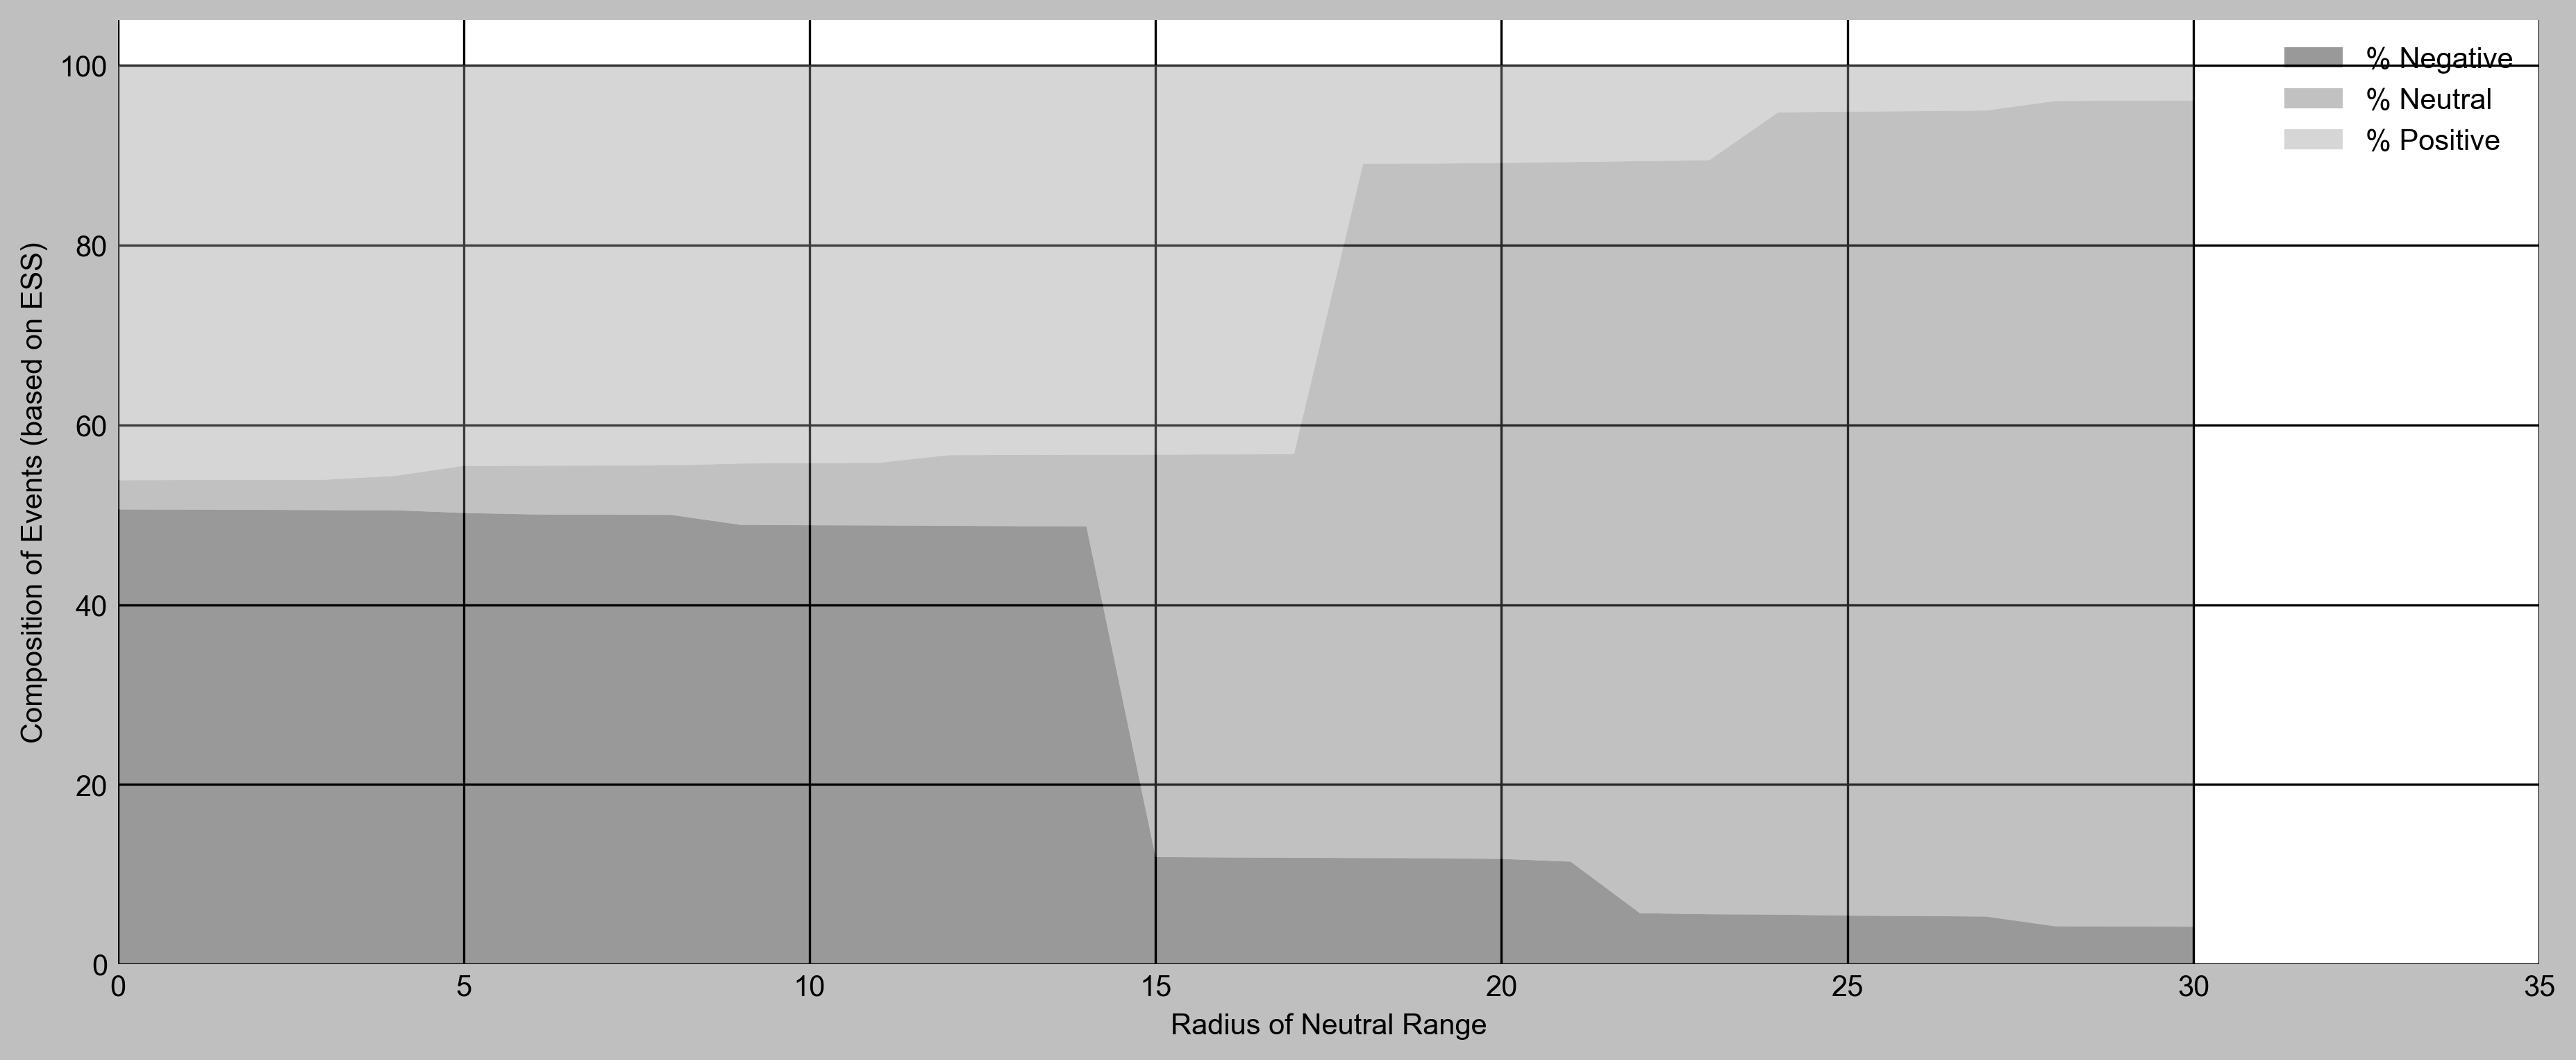

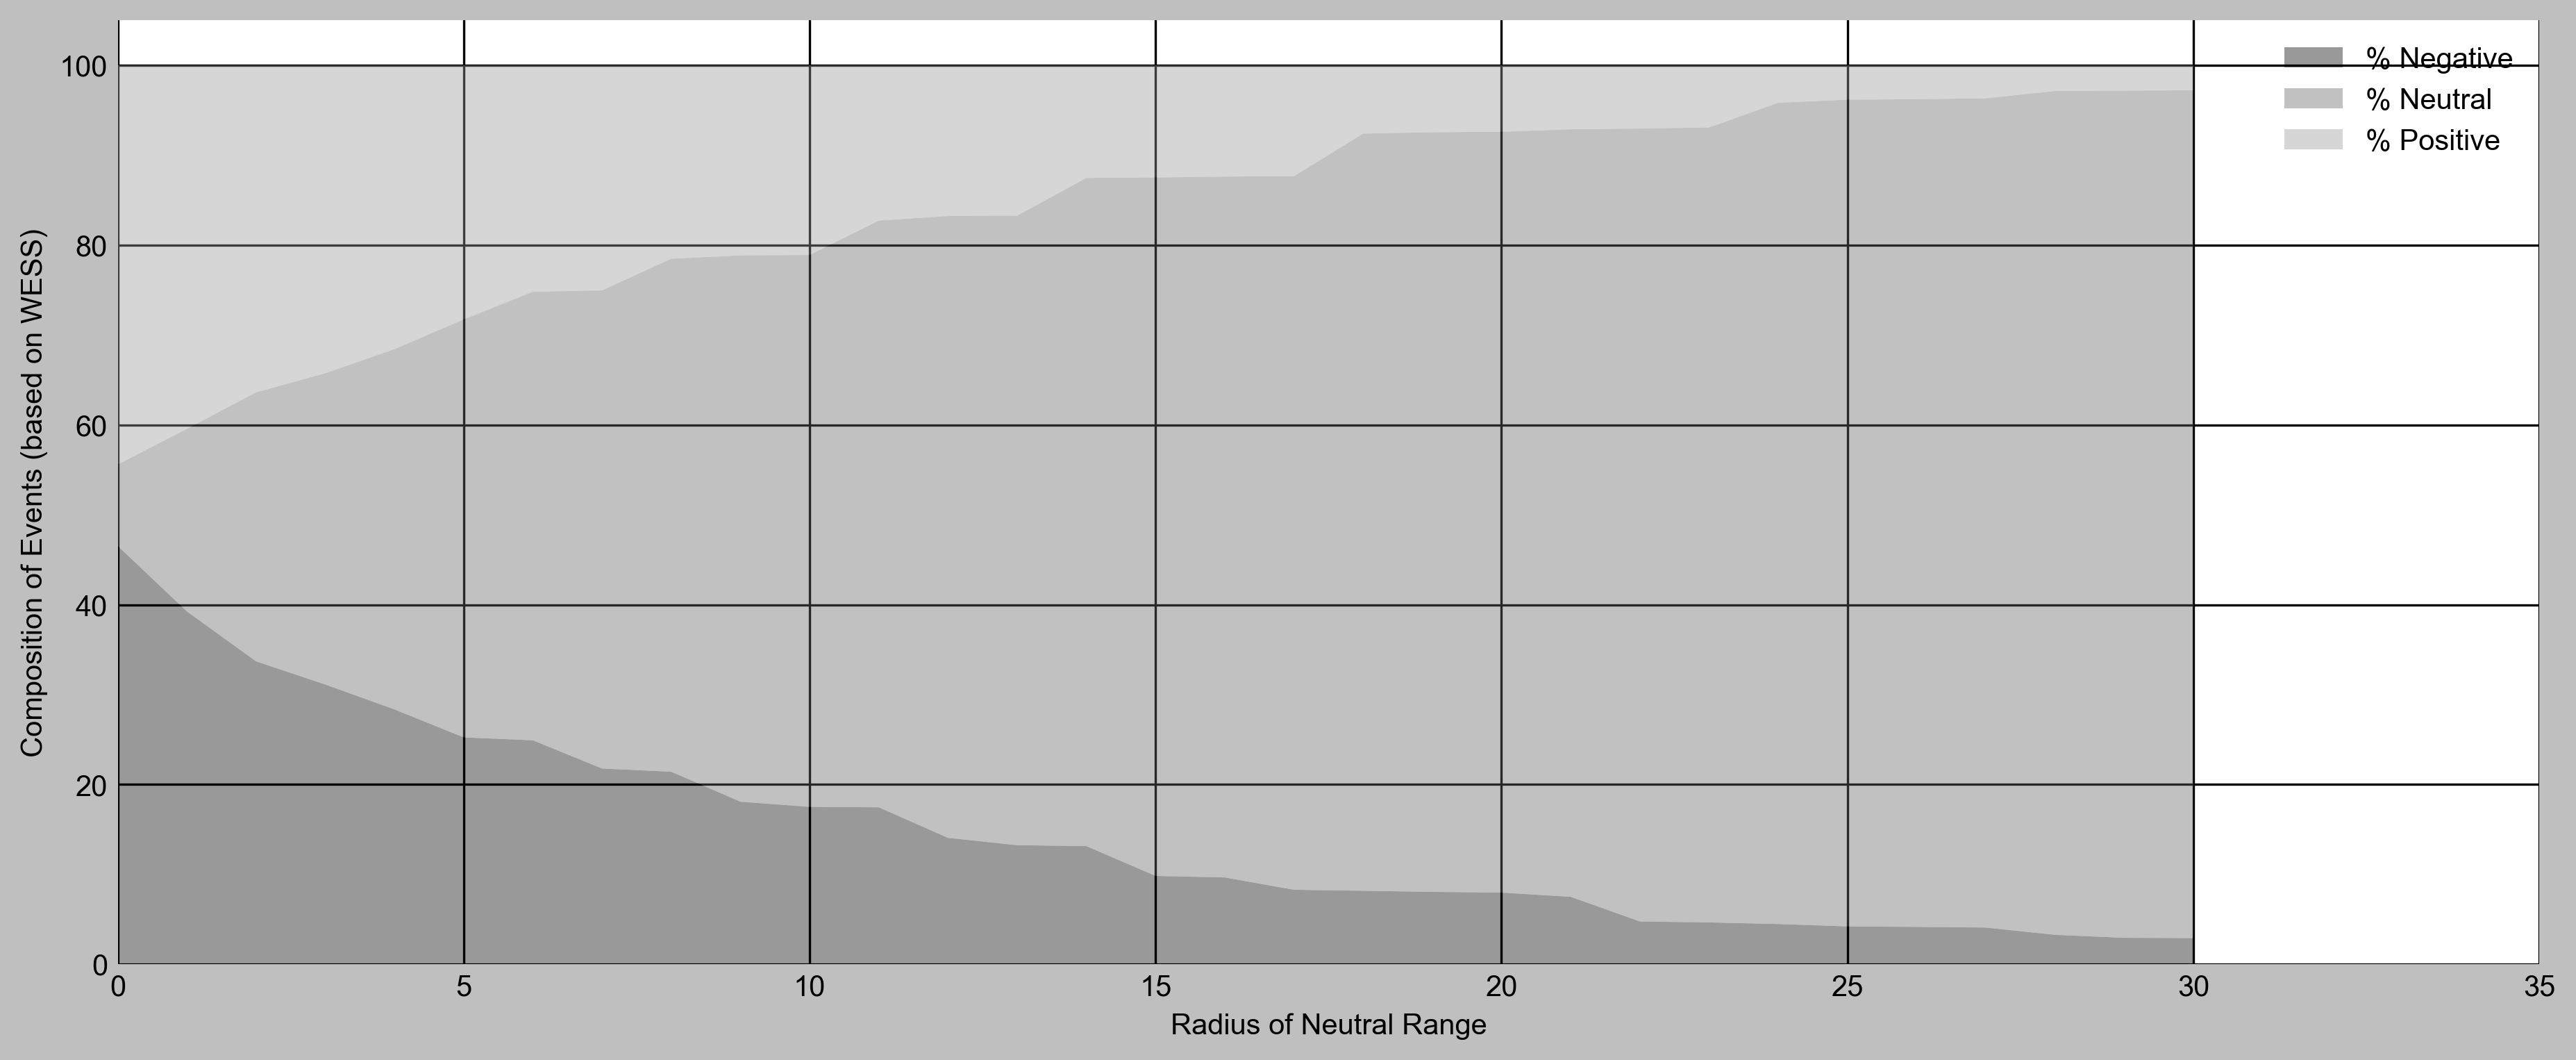

In [63]:
for col in ["ESS", "WESS"]:
    plt.close()
    # Basic stacked area chart.
    plt.rcParams["figure.figsize"] = (15, 6)
    N = 31
    x = range(N)
    neg_lst, neu_lst, pos_lst = [], [], []
    for lb, ub in zip([-x for x in range(N)], range(N)):
        neg = np.sum(df[col] < lb)
        pos = np.sum(df[col] > ub)
        neu = total - pos - neg

        neg_lst.append(neg / total * 100)
        neu_lst.append(neu / total * 100)
        pos_lst.append(pos / total * 100)

#     pal = sns.color_palette("Set1")

    fig, ax = plt.subplots()

    ax.stackplot(
        x, neg_lst, neu_lst, pos_lst,
        labels=["% Negative", "% Neutral", "% Positive"],
        alpha=0.4,
#         colors=pal
    )
    ax.set_xlabel("Radius of Neutral Range")
    ax.set_ylabel(f"Composition of Events (based on {col})")
    ax.set_xbound(0, 35)
    ax.legend(fancybox=True, shadow=True)
    plt.savefig(f"{fig_path}/{col}_composition.png", dpi=300, bbox_inches="tight")
    plt.show()